In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [ ]:
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    median_absolute_error,
    explained_variance_score,
    max_error
)

In [ ]:
filepath="/content/Annual_load_PV.csv"

In [ ]:

# 2. Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 3. Data Preparation
def prepare_data(filepath, seq_len=24, label_len=12, pred_len=12):
    df = pd.read_csv(filepath)
    df = df.loc[:100000]
    df['Net Load'] = df['Total Load'] - df['Total PV Gen']

    data = df['Net Load'].values.reshape(-1, 1)
    scaler = MinMaxScaler()
    data = scaler.fit_transform(data)

    X, y = [], []
    for i in range(len(data) - seq_len - pred_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len:i+seq_len+pred_len])

    X = np.array(X)
    y = np.array(y)
    train_size = int(len(X) * 0.8)
    return X[:train_size], y[:train_size], X[train_size:], y[train_size:], scaler

# 4. Informer Components
class ProbSparseSelfAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()
        self.query_proj = nn.Linear(d_model, d_model)
        self.key_proj = nn.Linear(d_model, d_model)
        self.value_proj = nn.Linear(d_model, d_model)
        self.out_proj = nn.Linear(d_model, d_model)
        self.n_heads = n_heads
        self.scale = (d_model // n_heads) ** -0.5

    def forward(self, x):
        B, L, D = x.shape
        H = self.n_heads

        Q = self.query_proj(x).view(B, L, H, -1)
        K = self.key_proj(x).view(B, L, H, -1)
        V = self.value_proj(x).view(B, L, H, -1)

        scores = torch.einsum("blhd,bshd->bhls", Q, K) * self.scale
        attn = torch.softmax(scores, dim=-1)
        context = torch.einsum("bhls,bshd->blhd", attn, V).reshape(B, L, D)

        return self.out_proj(context)

# 5. Informer Encoder Block
class InformerBlock(nn.Module):
    def __init__(self, d_model, n_heads, dropout=0.1):
        super().__init__()
        self.attn = ProbSparseSelfAttention(d_model, n_heads)
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_model * 4),
            nn.ReLU(),
            nn.Linear(d_model * 4, d_model),
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x2 = self.attn(x)
        x = x + self.dropout(x2)
        x = self.norm1(x)

        x2 = self.ff(x)
        x = x + self.dropout(x2)
        x = self.norm2(x)
        return x

# 6. Informer Model
class Informer(nn.Module):
    def __init__(self, input_dim=1, d_model=32, n_heads=4, seq_len=24, pred_len=12):
        super().__init__()
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.embed = nn.Linear(input_dim, d_model)
        self.encoder = InformerBlock(d_model, n_heads)
        self.decoder = nn.GRU(d_model, d_model, batch_first=True)
        self.projection = nn.Linear(d_model, input_dim)

    def forward(self, x):
        x = self.embed(x)
        x = self.encoder(x)
        dec_input = x[:, -1:, :].repeat(1, self.pred_len, 1)
        dec_output, _ = self.decoder(dec_input)
        return self.projection(dec_output)

# 7. Train Function
def train_model(X_train, y_train, X_test, y_test, epochs=30, batch_size=64):
    model = Informer().to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")
    return model

In [ ]:
def evaluate_model(model, X_test, y_test, scaler, plot_samples=100):
    model.eval()
    with torch.no_grad():
        test_inputs = torch.FloatTensor(X_test).to(device)
        test_outputs = model(test_inputs).cpu().numpy()

    # Reshape to 2D for inverse transform and metric calculation
    test_preds = test_outputs.reshape(-1, test_outputs.shape[-1])  # Reshape before inverse transform
    test_preds = scaler.inverse_transform(test_preds)

    # Reshape y_test to 2D for inverse transform and metric calculation
    test_actual = y_test.reshape(-1, y_test.shape[-1])  # Reshape before inverse transform
    test_actual = scaler.inverse_transform(test_actual)

    # Calculate metrics using the reshaped 2D arrays
    metrics = {
        'MAE': mean_absolute_error(test_actual, test_preds),
        'MSE': mean_squared_error(test_actual, test_preds),
        'RMSE': np.sqrt(mean_squared_error(test_actual, test_preds)),
        'R2': r2_score(test_actual, test_preds),
        'MedAE': median_absolute_error(test_actual, test_preds),
        'Explained Variance': explained_variance_score(test_actual, test_preds),
        'Max Error': max_error(test_actual, test_preds)
    }

    # Print metrics
    print("\nEvaluation Metrics:")
    for name, value in metrics.items():
        print(f"{name}: {value:.4f}{'%' if name == 'MAPE' else ''}")

    # Reshape back to 3D for plotting if needed
    test_preds = test_preds.reshape(test_outputs.shape)  # Reshape back to original shape
    test_actual = test_actual.reshape(y_test.shape)  # Reshape back to original shape


    plt.figure(figsize=(15, 10))

    # Plot first n samples
    plt.subplot(2, 1, 1)
    # Squeezing the dimensions to get 1D arrays for plotting
    plt.plot(test_actual.flatten(), label='Actual', marker='o', markersize=3)
    plt.plot(test_preds.flatten(), label='Predicted', marker='x', markersize=3)
    plt.title(f'First {plot_samples} Samples Comparison')
    plt.xlabel('Time Steps')
    plt.ylabel('Net Load')
    plt.legend()

    # Scatter plot
    plt.subplot(2, 1, 2)
    plt.scatter(test_actual, test_preds, alpha=0.5)
    plt.plot([min(test_actual.flatten()), max(test_actual.flatten())], [min(test_actual.flatten()), max(test_actual.flatten())], 'r--') # Updated to flatten test_actual for min/max
    plt.title('Actual vs Predicted Values')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')

    plt.tight_layout()
    plt.show()

    return metrics

In [ ]:
# Prepare data
X_train, y_train, X_test, y_test, scaler = prepare_data(filepath)

# Train the Informer model
model = train_model(X_train, y_train, X_test, y_test, epochs=30, batch_size=64)


Epoch 1/30, Loss: 3.4236
Epoch 2/30, Loss: 2.3822
Epoch 3/30, Loss: 2.3540
Epoch 4/30, Loss: 2.3063
Epoch 5/30, Loss: 2.2658
Epoch 6/30, Loss: 2.2377
Epoch 7/30, Loss: 2.1990
Epoch 8/30, Loss: 2.1992
Epoch 9/30, Loss: 2.1540
Epoch 10/30, Loss: 2.1348
Epoch 11/30, Loss: 2.1159
Epoch 12/30, Loss: 2.1226
Epoch 13/30, Loss: 2.1104
Epoch 14/30, Loss: 2.0980
Epoch 15/30, Loss: 2.1058
Epoch 16/30, Loss: 2.0814
Epoch 17/30, Loss: 2.0797
Epoch 18/30, Loss: 2.0686
Epoch 19/30, Loss: 2.0822
Epoch 20/30, Loss: 2.0577
Epoch 21/30, Loss: 2.0577
Epoch 22/30, Loss: 2.0484
Epoch 23/30, Loss: 2.0514
Epoch 24/30, Loss: 2.0462
Epoch 25/30, Loss: 2.0327
Epoch 26/30, Loss: 2.0426
Epoch 27/30, Loss: 2.0228
Epoch 28/30, Loss: 2.0233
Epoch 29/30, Loss: 2.0214
Epoch 30/30, Loss: 2.0146



Evaluation Metrics:
MAE: 0.2140
MSE: 0.1795
RMSE: 0.4236
R2: 0.8829
MedAE: 0.1036
Explained Variance: 0.8835
Max Error: 6.2165


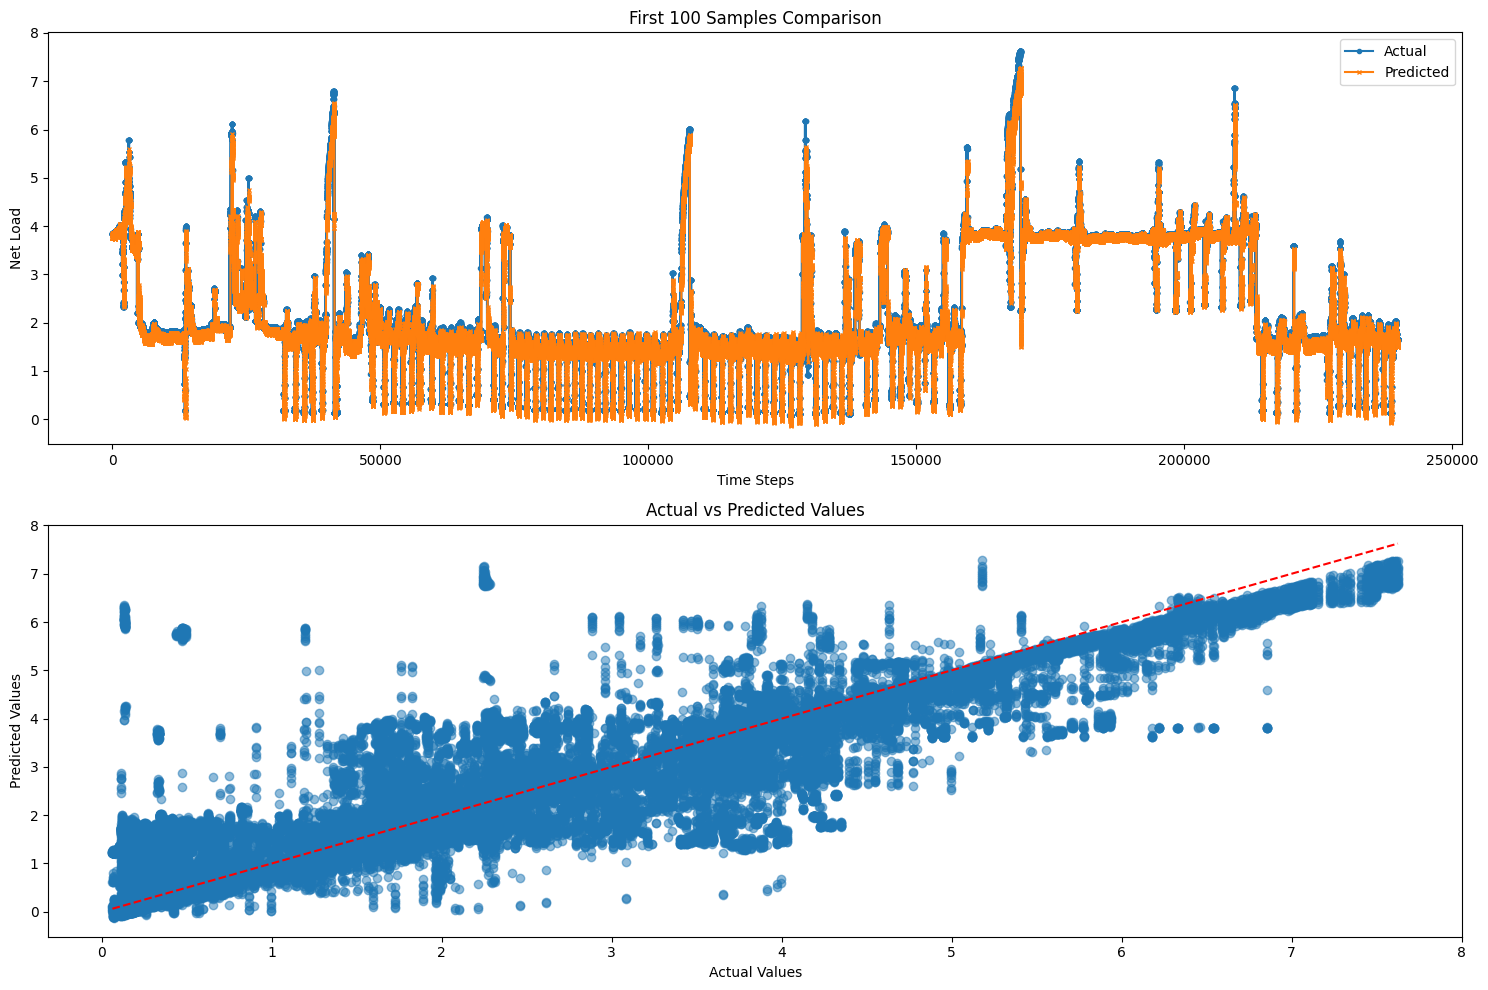

{'MAE': 0.2140159973574356,
 'MSE': 0.1794606093366458,
 'RMSE': np.float64(0.42362791378360065),
 'R2': 0.8828739511019318,
 'MedAE': np.float64(0.10363806676864618),
 'Explained Variance': 0.8834887414552007,
 'Max Error': np.float64(6.216493980407715)}

In [ ]:
# Evaluate and plot results
evaluate_model(model, X_test, y_test, scaler, plot_samples=100)

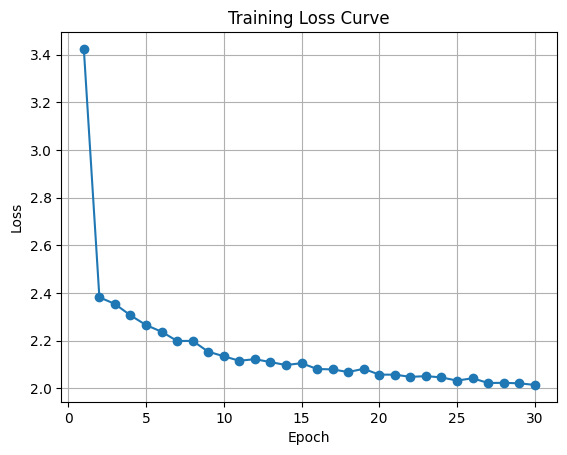

In [ ]:
loss_values = [
    3.4236, 2.3822, 2.3540, 2.3063, 2.2658, 2.2377, 2.1990, 2.1992, 2.1540, 2.1348,
    2.1159, 2.1226, 2.1104, 2.0980, 2.1058, 2.0814, 2.0797, 2.0686, 2.0822, 2.0577,
    2.0577, 2.0484, 2.0514, 2.0462, 2.0327, 2.0426, 2.0228, 2.0233, 2.0214, 2.0146
]
epochs = list(range(1, 31))  # 1 to 30
plt.plot(epochs, loss_values, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.grid(True)
plt.show()